In [99]:
from re import A
import pennylane as qml
import jax
from jax import numpy as jnp
import jaxopt

import os
os.system("export OMP_NUM_THREADS=6")

jax.config.update("jax_platform_name", "cpu")

n_wires = 8

dev = qml.device("default.qubit", wires=n_wires)

def chebyshev_feature_map(x, wires = range(n_wires)):
    for i in wires:
        qml.RY(2*jnp.arccos(x),i)

@qml.qnode(dev)
def circuit(data, weights):
    """Quantum circuit ansatz"""

    # data embedding
    chebyshev_feature_map(data)
    # for i in range(n_wires):
    #     # data[i] will be of shape (4,); we are
    #     # taking advantage of operation vectorization here
    #     qml.RY(data, wires=i)

    # trainable ansatz
    for i in range(n_wires):
        qml.RX(weights[i, 0], wires=i)
        qml.RY(weights[i, 1], wires=i)
        qml.RX(weights[i, 2], wires=i)
        qml.CNOT(wires=[i, (i + 1) % n_wires])

    # we use a sum of local Z's as an observable since a
    # local Z would only be affected by params on that qubit.
    return qml.expval(qml.sum(*[qml.PauliZ(i) for i in range(n_wires)]))


def my_model(data, weights, bias):
    return circuit(data, weights) + bias

@jax.jit
def target_fnc(data):
    return jnp.sin(data*2*jnp.pi)
    
@jax.jit
def loss_fn(params):
    data = jnp.linspace(0.0, 1.0, 21)
    
    targets = target_fnc(data)

    predictions = my_model(data, params["weights"], params["bias"])
    loss = jnp.mean((targets - predictions) ** 2)
    return loss

weights = jnp.ones([n_wires, 3])
bias = jnp.array(0.)
params = {"weights": weights, "bias": bias}

def loss_and_grad(params, print_training, i):
    loss_val, grad_val = jax.value_and_grad(loss_fn)(params)

    print_fn = lambda: jax.debug.print("Step: {i}  Loss: {loss_val}", i=i, loss_val=loss_val)

    #if print_training=True, print the loss every 100 steps
    jax.lax.cond((jnp.mod(i, 100) == 0) & print_training, print_fn, lambda: None)

    return loss_val, grad_val

opt = jaxopt.GradientDescent(loss_and_grad, stepsize=0.1, value_and_grad=True)
opt_state = opt.init_state(params)

def optimize(params, opt_state):
    loss_history = []
    current_lowest_loss = 1000
    best_params = params
    best_opt_state = opt_state
    for i in range(1000):
        params, opt_state = opt.update(params, opt_state, True, i)
        loss = loss_fn(params)
        loss_history.append(loss)
        if loss < current_lowest_loss:
            current_lowest_loss = loss
            best_params = params
            best_opt_state = opt_state
            
    return best_params, best_opt_state, loss_history

        
# %timeit -r1 -n1 optimize(params, opt_state, data, targets)



In [100]:
params, opt_state, loss_history = optimize(params, opt_state)

Step: 0  Loss: 6.55930757522583
Step: 100  Loss: 0.00463389465585351
Step: 200  Loss: 0.0013234842335805297
Step: 300  Loss: 0.00063320342451334
Step: 400  Loss: 0.0003657092456705868
Step: 500  Loss: 0.000255905237281695
Step: 600  Loss: 0.00016473265714012086
Step: 700  Loss: 0.00011210152297280729
Step: 800  Loss: 8.807807898847386e-05
Step: 900  Loss: 4.281907604308799e-05


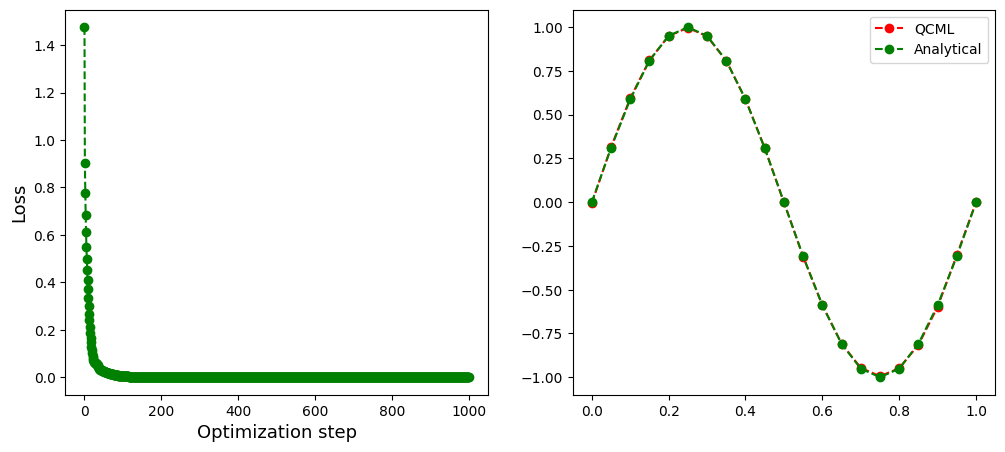

In [101]:
import matplotlib.pyplot as plt

fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(12)

# Add energy plot on column 1
ax1 = fig.add_subplot(121)
ax1.plot(range(len(loss_history)), loss_history, "go", ls="dashed")
ax1.set_xlabel("Optimization step", fontsize=13)
ax1.set_ylabel("Loss", fontsize=13)

ax2 = fig.add_subplot(122)
x = jnp.linspace(0,1,21)
f_qc = my_model(x, params["weights"], params["bias"])
f_an = target_fnc(x)
ax2.plot( x, f_qc, "ro", ls="dashed")
ax2.plot( x, f_an, "go", ls="dashed")
ax2.legend(["QCML", "Analytical"])

plt.show()

In [39]:
my_model(x, params["weights"], params["bias"])

Array([0.00109576, 0.11031701, 0.21996476, 0.32743078, 0.4305572 ,
       0.5277788 , 0.6181187 , 0.7010258 , 0.77607626, 0.84259313],      dtype=float32)

In [56]:
params["bias"]

Array(-0.27642432, dtype=float32, weak_type=True)